In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud import bigquery_storage
import time
import base64
import json
import os

secrets = os.environ['csw_gcp_secret']
service_account_creds = json.loads(base64.b64decode(secrets))

 

bq_project = 'bcs-breeding-datasets'
bq_credentials = service_account.Credentials.from_service_account_info(service_account_creds)

 

bq_client = bigquery.Client(credentials=bq_credentials, project=bq_project)
bq_storageclient = bigquery_storage.BigQueryReadClient(credentials=bq_credentials)

In [4]:
configuration = {
   'query': {
     "useQueryCache": False
   }
}

# Perform a query.
QUERY1 = f"""
SELECT
  machine_location,
  machine_serial,
  src_plot_bid,
  min(EXTRACT(Datetime from datetime_start)) as datetime_start,
  max(EXTRACT(Datetime from datetime_finish)) as datetime_finish
      
FROM
  `bcs-breeding-datasets.breeding_operations.mactracker_shellmatic_3`
WHERE
  EXTRACT(YEAR
  FROM
    datetime_start) = 2024
  AND machine_location in ("HAZ","WIB","SOG","RAG")
  AND src_plot_bid <> "CALIBRATION"
  and datetime_finish is not null
GROUP BY 1,2,3

"""

# Dataframe of GCP data
df_raw = (
    bq_client.query(QUERY1)
    .result()
    .to_dataframe(bqstorage_client=bq_storageclient)
)

In [5]:
df_raw.head()

,machine_location,machine_serial,src_plot_bid,datetime_start,datetime_finish
0,HAZ,5,P00000000879564716868380,2024-01-25 19:16:38,2024-01-25 19:26:07
1,WIB,4,P00000000879564414116637,2024-01-26 14:34:01,2024-01-26 14:35:02
2,WIB,4,P00000000879564414116611,2024-01-26 17:25:37,2024-01-26 17:26:34
3,WIB,4,23S8M1,2024-01-26 20:30:38,2024-01-26 20:33:34
4,WIB,4,23S4YC,2024-01-26 21:34:47,2024-01-26 21:38:54


In [6]:
# set threshold of what should be considered downtime
# here chose 5 minutes
downtime_threshold_seconds = 5 * 60

#### Processing time for each source plot

In [7]:
# update data types
df_raw['date'] = df_raw.datetime_finish.dt.date
df_raw['machine_serial'] = df_raw.machine_serial.astype(int)
# TODO: fix this
df_raw['category'] = 'none'
# df_raw['category'] = np.where(df_raw.machine_id.isin(cat_3), 'cat 3', 'cat 2')
df_raw['processing_time_srcplot'] = df_raw['datetime_finish'] - df_raw['datetime_start']
df_raw['processing_in_seconds'] = df_raw['processing_time_srcplot'].dt.total_seconds()

In [8]:
df_raw.head()

,machine_location,machine_serial,src_plot_bid,datetime_start,datetime_finish,date,category,processing_time_srcplot,processing_in_seconds
0,HAZ,5,P00000000879564716868380,2024-01-25 19:16:38,2024-01-25 19:26:07,2024-01-25,none,0 days 00:09:29,569.0
1,WIB,4,P00000000879564414116637,2024-01-26 14:34:01,2024-01-26 14:35:02,2024-01-26,none,0 days 00:01:01,61.0
2,WIB,4,P00000000879564414116611,2024-01-26 17:25:37,2024-01-26 17:26:34,2024-01-26,none,0 days 00:00:57,57.0
3,WIB,4,23S8M1,2024-01-26 20:30:38,2024-01-26 20:33:34,2024-01-26,none,0 days 00:02:56,176.0
4,WIB,4,23S4YC,2024-01-26 21:34:47,2024-01-26 21:38:54,2024-01-26,none,0 days 00:04:07,247.0


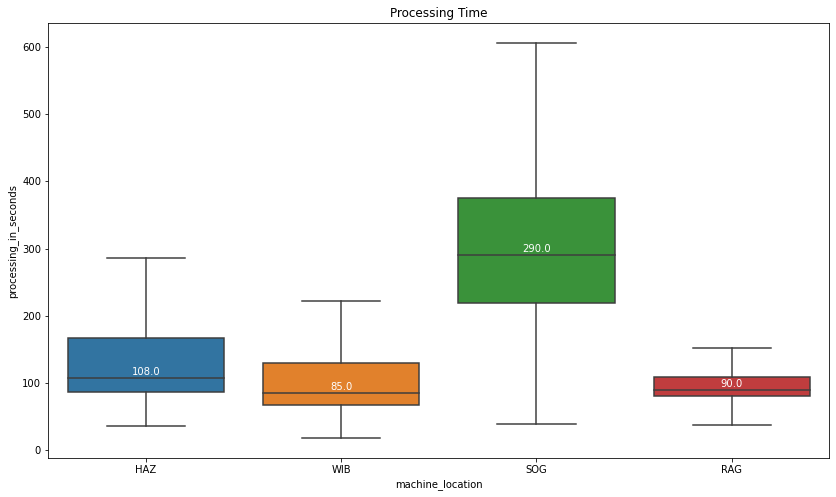

In [9]:
medians = df_raw.groupby('machine_location')['processing_in_seconds'].median().round(1)
# fig, ax = plt.subplots()
plt.figure(figsize=(14,8))
box_plot_p = sns.boxplot(data=df_raw, x='machine_location', y='processing_in_seconds', showfliers=False) 
box_plot_p.set_title('Processing Time')
vertical_offset = df_raw['processing_in_seconds'].median() *0.05


for xtick, loc in enumerate(df_raw['machine_location'].unique()):
    median_val = medians.loc[loc]
    box_plot_p.text(xtick, median_val+vertical_offset, median_val, horizontalalignment='center',color='w')

In [10]:
# stats including outliers

stats_p = df_raw.groupby('machine_location')['processing_in_seconds'].describe().round(1)
stats_p

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,4377.0,623.9,18063.9,36.0,87.0,108.0,167.0,839623.0
RAG,35176.0,169.1,8209.0,23.0,80.0,90.0,109.0,1120313.0
SOG,903.0,24972.1,187395.7,39.0,218.5,290.0,374.5,1882406.0
WIB,38227.0,4027.2,84173.1,18.0,67.0,85.0,129.0,2762774.0


In [11]:
#df_raw.groupby('machine_location')['src_plot_bid'].describe().round(1)

In [12]:
# stats excluding outliers

def filter_outliers(group):
    Q1 = group['processing_in_seconds'].quantile(0.25)
    Q3 = group['processing_in_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['processing_in_seconds'] >= lower_bound) & (group['processing_in_seconds'] <= upper_bound)]

df_raw_filetered = df_raw.groupby('machine_location').apply(filter_outliers).reset_index(drop=True)


In [13]:
stats_p_filetered = df_raw_filetered.groupby('machine_location')['processing_in_seconds'].describe().round(1)
stats_p_filetered

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,4033.0,121.8,53.0,36.0,86.0,104.0,145.0,286.0
RAG,28230.0,96.3,19.9,37.0,84.0,93.0,109.0,152.0
SOG,861.0,280.7,125.9,39.0,212.0,286.0,352.0,606.0
WIB,35325.0,94.6,40.0,18.0,65.0,82.0,118.0,222.0


#### Downtime between plots

In [14]:
df_raw = df_raw.sort_values(by=['machine_location','machine_serial','date','datetime_start'])
grouped = df_raw.groupby(['machine_location','machine_serial','date'])

def cal_downtime(group):
    group['next_datetime_start'] = group['datetime_start'].shift(-1)
    group['diff'] = group['next_datetime_start'] - group['datetime_finish']
    return group

df_downtime = grouped.apply(cal_downtime)
#df_downtime = df_downtime.drop(columns=['next_datetime_start'])

In [15]:
df_downtime['diff_in_seconds'] = df_downtime['diff'].dt.total_seconds()

In [16]:
#df_downtime.tail()

In [17]:
# make the ones with negative diff 0 downtime because that's an overlap therefore no downtime between the two
df_downtime['downtime_in_seconds'] = np.where(df_downtime['diff_in_seconds']>0,df_downtime['diff_in_seconds'],0)

In [18]:
#df_downtime.tail()

(0.0, 600.0)

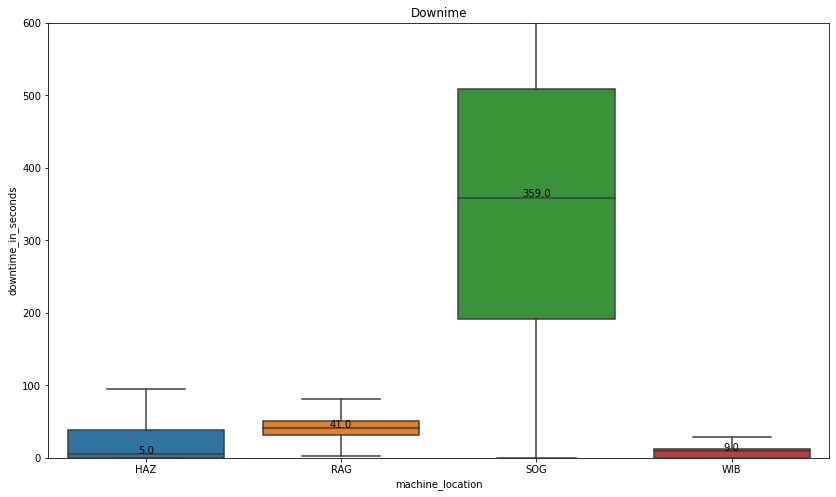

In [19]:
medians_d = df_downtime.groupby('machine_location')['downtime_in_seconds'].median().round(1)

plt.figure(figsize=(14,8))
box_plot_d = sns.boxplot(data=df_downtime, x='machine_location', y='downtime_in_seconds', showfliers=False) 
box_plot_d.set_title('Downime')
vertical_offset_d = df_downtime['downtime_in_seconds'].median() *0.05


for xtick, loc in enumerate(df_downtime['machine_location'].unique()):
    median_val = medians_d.loc[loc]
    box_plot_d.text(xtick, median_val+vertical_offset_d, median_val, horizontalalignment='center',color='black')
    
plt.ylim(0,600)

In [20]:
# stats including outliers

stats_d = df_downtime.groupby('machine_location')['downtime_in_seconds'].describe().round()
stats_d

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,4377.0,205.0,1048.0,0.0,0.0,5.0,38.0,20204.0
RAG,35176.0,296.0,3278.0,0.0,31.0,41.0,51.0,60693.0
SOG,903.0,693.0,1225.0,0.0,191.0,359.0,510.0,13388.0
WIB,38227.0,159.0,2258.0,0.0,0.0,9.0,12.0,76684.0


In [21]:
# stats excluding outliers

def filter_outliers(group):
    Q1 = group['downtime_in_seconds'].quantile(0.25)
    Q3 = group['downtime_in_seconds'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['downtime_in_seconds'] >= lower_bound) & (group['downtime_in_seconds'] <= upper_bound)]


df_downtime_filetered = df_downtime.groupby('machine_location').apply(filter_outliers).reset_index(drop=True)


In [22]:
stats_d_filetered = df_downtime_filetered.groupby('machine_location')['downtime_in_seconds'].describe().round(1)
stats_d_filetered

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,3869.0,15.2,22.0,0.0,0.0,1.0,26.0,95.0
RAG,31901.0,39.2,14.4,2.0,30.0,40.0,48.0,81.0
SOG,780.0,314.0,183.6,0.0,175.8,322.0,433.0,948.0
WIB,32397.0,6.1,6.3,0.0,0.0,5.0,11.0,29.0


#### Understand machine run time

In [23]:
# run time is any time excluding gaps of more than 5 min
# what percent of records are downtime (gap > 5 min)?
np.round(df_downtime[df_downtime['downtime_in_seconds'] >= downtime_threshold_seconds].shape[0] / df_downtime.shape[0] * 100)

4.0

In [24]:
# calculate run time: if downtime is smaller than threshold, then run time = process time + down time; otherwise, run time = process time

df_downtime['run_time'] = np.where(df_downtime['downtime_in_seconds'] <= downtime_threshold_seconds,
                                df_downtime['downtime_in_seconds']+df_downtime['processing_in_seconds'], \
                                   df_downtime['processing_in_seconds'])

In [25]:
# get hours per day per machine
machine_run_time = df_downtime.groupby(
    ['machine_location','machine_serial','date','category']).run_time.sum().reset_index(name='runtime_seconds')
machine_run_time['runtime_hours'] = round(
    machine_run_time.runtime_seconds/60/60, 2)


In [26]:
#machine_run_time[machine_run_time['runtime_hours']>18]


In [27]:
# There are some plots that are processed across 2 dates, making the run time so long. Use a threshold to remove these 
Runtime_threshold = 18
np.round(machine_run_time[machine_run_time['runtime_hours'] >= Runtime_threshold].shape[0] / machine_run_time.shape[0] * 100)


4.0

In [28]:
machine_run_time = machine_run_time[machine_run_time['runtime_hours']<Runtime_threshold]

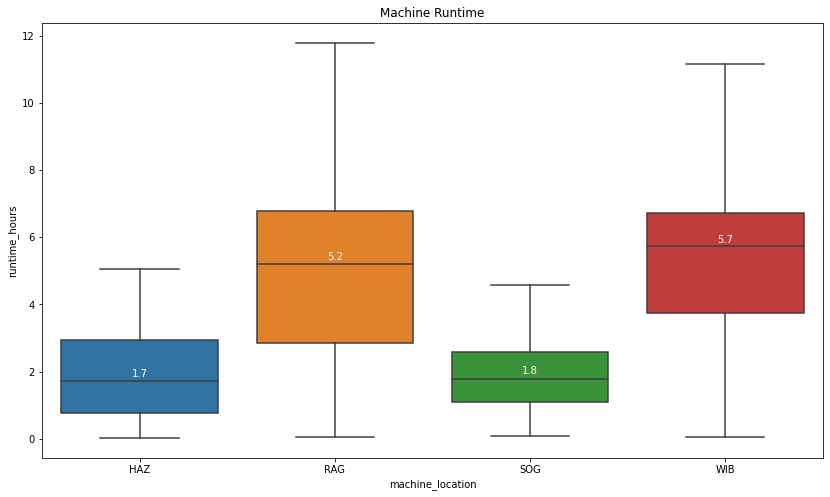

In [29]:
plt.figure(figsize=(14,8))

medians_run = machine_run_time.groupby('machine_location')['runtime_hours'].median().round(1)

box_plot_runtime = sns.boxplot(data=machine_run_time, x='machine_location',y='runtime_hours', showfliers=False)
box_plot_runtime.set_title('Machine Runtime')
vertical_offset_r = machine_run_time['runtime_hours'].median() *0.03


for xtick, loc in enumerate(machine_run_time['machine_location'].unique()):
    median_val = medians_run.loc[loc]
    box_plot_runtime.text(xtick, median_val + vertical_offset_r, median_val, horizontalalignment='center',color='w')
    

In [30]:
#[(machine_run_time.runtime_hours > 1)]
stats_m = machine_run_time.groupby('machine_location')['runtime_hours'].describe().round(1)
stats_m

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,118.0,2.1,2.1,0.0,0.8,1.7,3.0,16.6
RAG,277.0,5.0,2.7,0.1,2.8,5.2,6.8,13.2
SOG,48.0,1.9,1.1,0.1,1.1,1.8,2.6,5.4
WIB,279.0,5.3,2.6,0.0,3.8,5.7,6.7,15.2


In [107]:
# stats excluding outliers

def filter_outliers(group):
    Q1 = group['runtime_hours'].quantile(0.25)
    Q3 = group['runtime_hours'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['runtime_hours'] >= lower_bound) & (group['runtime_hours'] <= upper_bound)]


df_runtime_filetered = machine_run_time.groupby('machine_location').apply(filter_outliers).reset_index(drop=True)

stats_mr_filetered = df_runtime_filetered.groupby('machine_location')['runtime_hours'].describe().round(1)
stats_mr_filetered

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,113.0,1.9,1.3,0.0,0.8,1.6,2.9,5.1
RAG,274.0,4.9,2.6,0.1,2.8,5.2,6.7,11.8
SOG,47.0,1.8,1.0,0.1,1.1,1.8,2.5,4.6
WIB,275.0,5.2,2.4,0.0,3.7,5.7,6.7,11.2


In [31]:

# get plots processed per day per machine
machine_plots_processed = df_downtime.groupby(
    ['machine_location','machine_serial','date','category']).size().reset_index(name='n_plots_processed')

daily_df = pd.merge(machine_run_time, machine_plots_processed)

daily_df['plots_per_hour'] = daily_df['n_plots_processed'] / \
    daily_df['runtime_hours']

daily_df['date'] = pd.to_datetime(daily_df['date'])
daily_df.sort_values('date', inplace=True)

# additional date labels for plotting
daily_df['month_day'] = daily_df['date'].dt.strftime('%m-%d')
daily_df['week'] = daily_df['date'].dt.isocalendar().week

In [32]:
daily_df.head()

,machine_location,machine_serial,date,category,runtime_seconds,runtime_hours,n_plots_processed,plots_per_hour,month_day,week
395,SOG,1,2024-01-02,none,2853.0,0.79,10,12.658228,01-02,1
509,WIB,2,2024-01-03,none,18877.0,5.24,39,7.442748,01-03,1
571,WIB,3,2024-01-03,none,19070.0,5.30,13,2.452830,01-03,1
396,SOG,1,2024-01-03,none,9150.0,2.54,29,11.417323,01-03,1
647,WIB,4,2024-01-04,none,19641.0,5.46,144,26.373626,01-04,1


In [33]:
stats_ph = daily_df.groupby('machine_location')['plots_per_hour'].describe().round(0)
stats_ph

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,118.0,19.0,11.0,0.0,10.0,19.0,26.0,50.0
RAG,277.0,23.0,9.0,1.0,22.0,25.0,27.0,58.0
SOG,48.0,10.0,4.0,1.0,8.0,10.0,12.0,25.0
WIB,279.0,22.0,15.0,1.0,9.0,20.0,35.0,60.0


In [109]:
# stats excluding outliers

def filter_outliers(group):
    Q1 = group['plots_per_hour'].quantile(0.25)
    Q3 = group['plots_per_hour'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['plots_per_hour'] >= lower_bound) & (group['plots_per_hour'] <= upper_bound)]


df_plots_filetered = daily_df.groupby('machine_location').apply(filter_outliers).reset_index(drop=True)

stats_plots_filetered = df_plots_filetered.groupby('machine_location')['plots_per_hour'].describe().round(1)
stats_plots_filetered

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,117.0,18.2,10.5,0.1,10.2,19.1,25.6,43.2
RAG,209.0,25.2,3.3,14.6,23.7,25.0,26.8,34.3
SOG,44.0,9.8,2.6,3.0,8.1,9.6,11.2,16.9
WIB,279.0,22.4,15.2,0.8,9.0,20.4,34.6,59.9


#### Number of machines running

In [34]:
# number of machines running per day
n_machines = daily_df.groupby(['machine_location','date', 'category']).machine_serial.nunique()
n_machines = n_machines.reset_index(name='n_machines')
n_machines.sort_values('date', inplace=True)

In [106]:
# n_machines

In [35]:
stats_nm = n_machines.groupby('machine_location')['n_machines'].describe().round(0)
stats_nm

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,62.0,2.0,1.0,1.0,1.0,2.0,3.0,4.0
RAG,64.0,4.0,2.0,1.0,2.0,5.0,6.0,6.0
SOG,48.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
WIB,95.0,3.0,1.0,1.0,2.0,3.0,4.0,4.0


In [108]:
# stats excluding outliers

def filter_outliers(group):
    Q1 = group['n_machines'].quantile(0.25)
    Q3 = group['n_machines'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['n_machines'] >= lower_bound) & (group['n_machines'] <= upper_bound)]


df_nmachine_filetered = n_machines.groupby('machine_location').apply(filter_outliers).reset_index(drop=True)

stats_nmc_filetered = df_nmachine_filetered.groupby('machine_location')['n_machines'].describe().round(1)
stats_nmc_filetered

,count,mean,std,min,25%,50%,75%,max
machine_location,,,,,,,,
HAZ,62.0,1.9,0.9,1.0,1.0,2.0,2.8,4.0
RAG,64.0,4.3,2.0,1.0,2.0,5.0,6.0,6.0
SOG,48.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
WIB,95.0,2.9,1.2,1.0,2.0,3.0,4.0,4.0


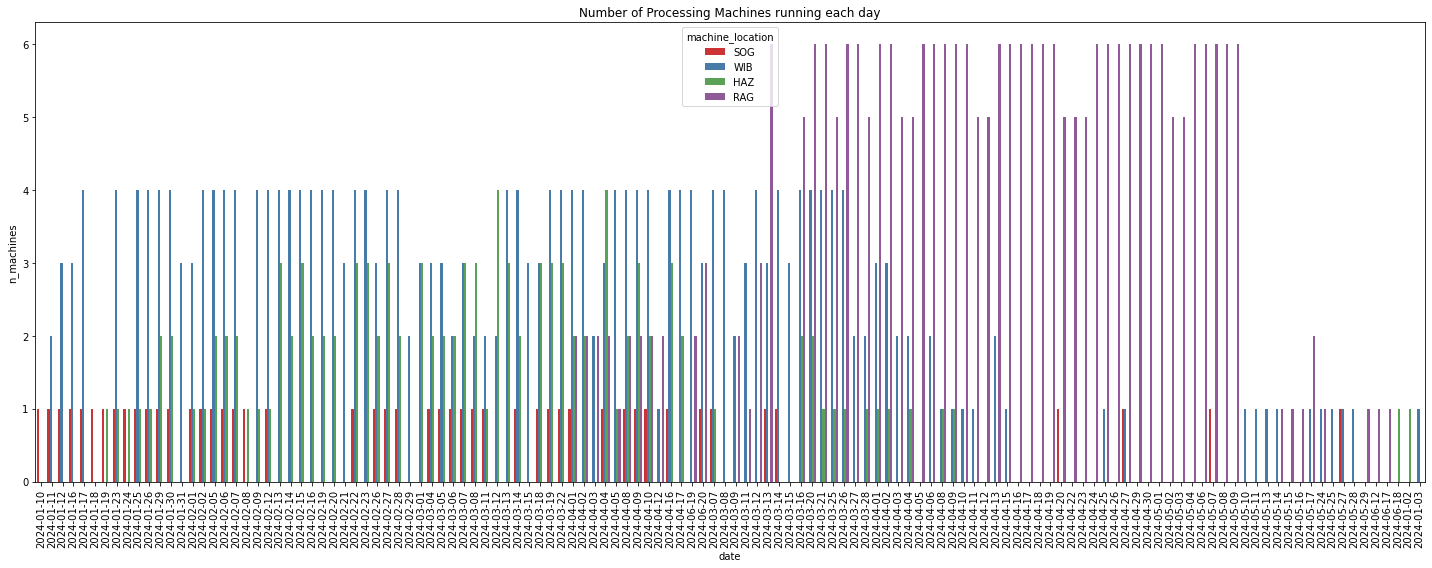

In [84]:
n_machines['date'] = pd.to_datetime(n_machines['date'], format='%Y-%m-%d')

plt.figure(figsize=(20,8))
ax = sns.barplot(data=n_machines, x='date', y='n_machines', hue='machine_location', dodge=True, ci=None, palette='Set1', saturation=0.75)
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_formatter(plt.FixedFormatter(n_machines['date'].dt.strftime("%Y-%m-%d")))


_=ax.set_title('Number of Processing Machines running each day')

plt.tight_layout()
plt.show()

#### Plots processed per machine per hour

Filtered out observations of more than **100** plots per hour as outliers because 100 would be processing a plot every 36 seconds. 

Some outliers were created by manual uploads that assigned data to the time of the upload, not the time the work was completed.

In [89]:
# daily_df_grouped = daily_df.groupby(['machine_location','date','month_day'])['plots_per_hour'].mean().reset_index(name='plots_per_hour')

In [99]:
# daily_df_grouped.head()

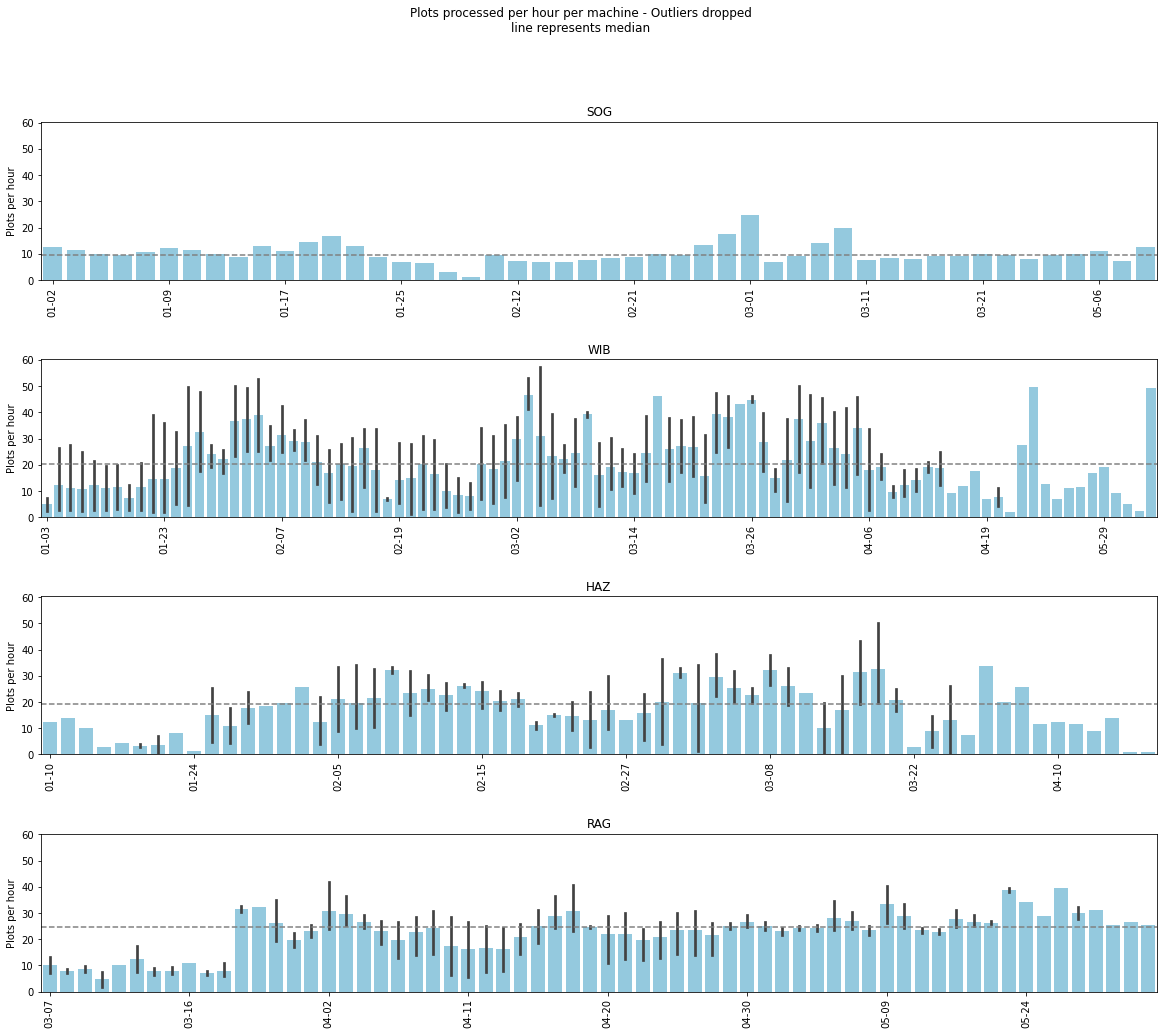

In [101]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=False, sharey=True,figsize=(20, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})

plt.subplots_adjust(hspace=0.5)
fig.suptitle("Plots processed per hour per machine - Outliers dropped\nline represents median")
machine_location = daily_df.machine_location.unique()
axes = axs.flatten()
# # loop through sites and axes
for s, ax in zip(machine_location, axes):
    g = sns.barplot(data=daily_df[(daily_df.plots_per_hour <= 100) & (daily_df.machine_location == s)],
                x='month_day', y='plots_per_hour', ax=ax,color='skyblue')
    g.axhline(y=daily_df[(daily_df.plots_per_hour <= 100) & (daily_df.machine_location == s)].plots_per_hour.median(),
        c='grey', linestyle='dashed')
    g.tick_params(axis='x', rotation=90)
    g.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    g.set(xlabel=None, title=s, ylabel='Plots per hour')
#fig.tight_layout()

In [97]:
# daily_df[(daily_df.plots_per_hour <= 100) & (daily_df.machine_location == "SOG")]

In [105]:
print('Plots per hour per machine summary statistics\n')
print(daily_df[(daily_df.plots_per_hour <= 100)].groupby(['machine_location']).plots_per_hour.describe()[[
    'count', '25%', '50%', '75%', 'max'
]])
print('\n By week: \n')
print(daily_df[(daily_df.plots_per_hour <= 100)].groupby(['machine_location', 'week']).plots_per_hour.describe()[[
    'count', '25%', '50%', '75%', 'max'
]])

Plots per hour per machine summary statistics

                  count        25%        50%        75%        max
machine_location                                                   
HAZ               118.0  10.278000  19.232793  25.735617  50.000000
RAG               277.0  22.061856  24.715909  27.083333  58.174098
SOG                48.0   8.073113   9.625944  11.602208  25.000000
WIB               279.0   9.001924  20.430108  34.553613  59.892569

 By week: 

                       count        25%        50%        75%        max
machine_location week                                                   
HAZ              2       3.0  11.250000  12.500000  13.194444  13.888889
                 3       6.0   2.714286   3.351648   4.370629   7.142857
                 4       6.0   4.411002   6.605691  15.455426  25.179856
                 5       8.0  11.722488  19.105127  22.265886  25.547445
                 6      11.0  12.781955  30.973451  32.884566  33.952255
                 7   

#### Runtime per machine per day

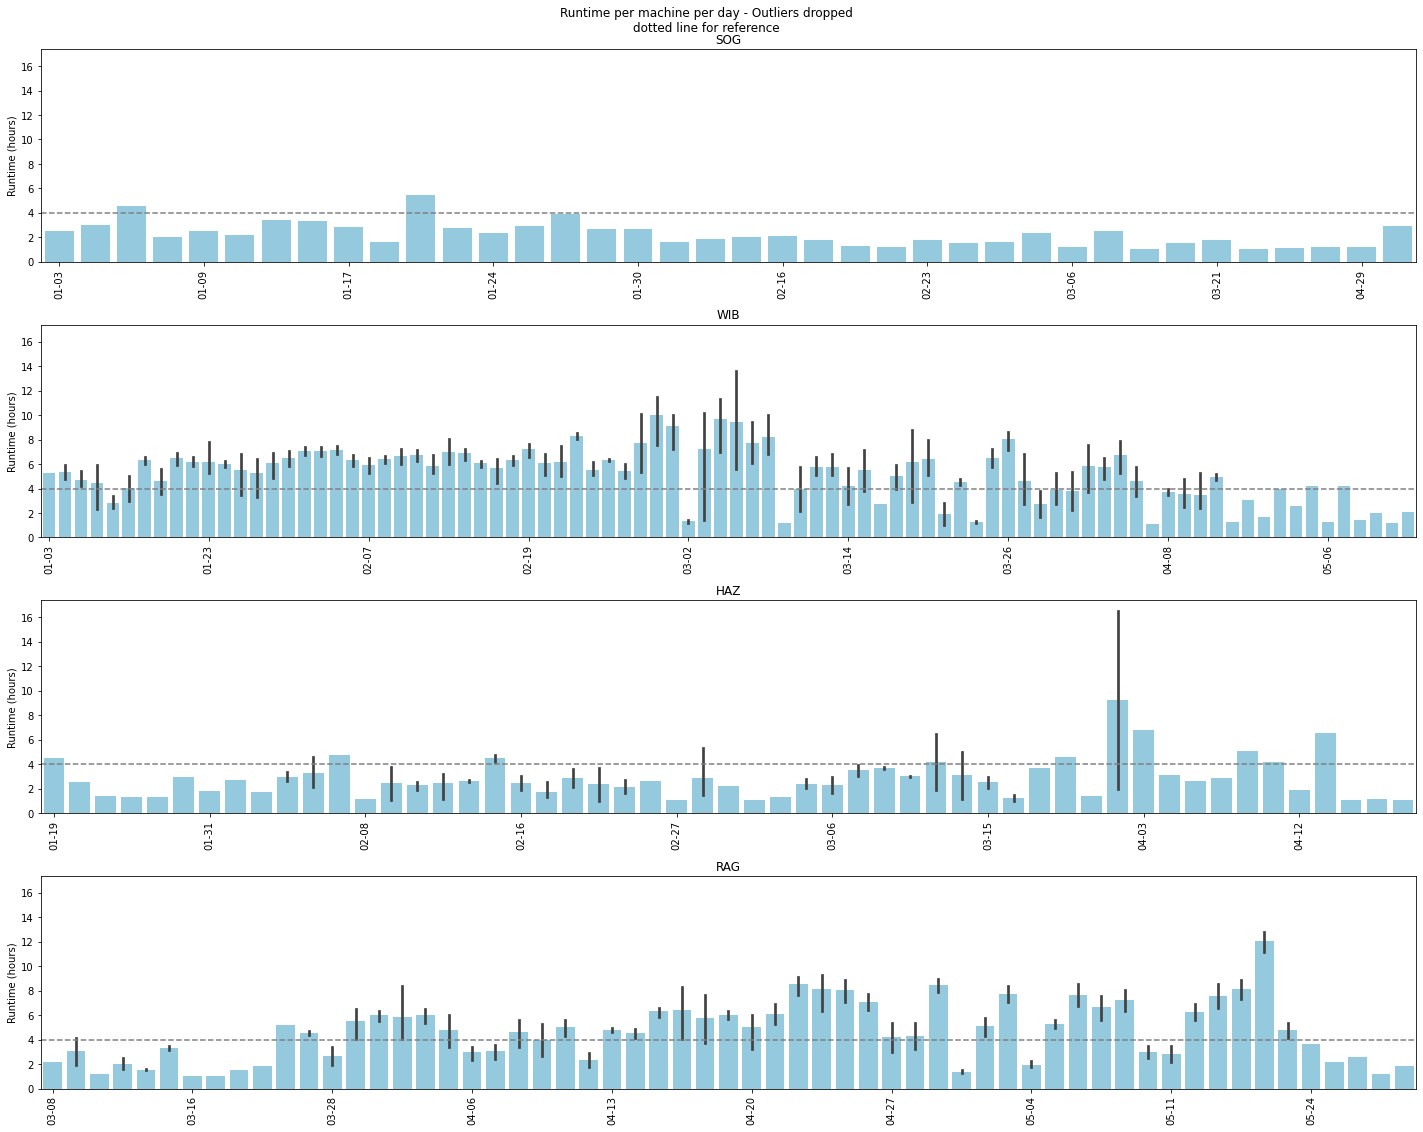

In [102]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=False,
                        sharey=True,figsize=(20, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})  
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Runtime per machine per day - Outliers dropped\ndotted line for reference")
machine_location = daily_df.machine_location.unique()
axes = axs.flatten()
# # loop through sites and axes
for s, ax in zip(machine_location, axes):
    g = sns.barplot(data=daily_df[(daily_df.runtime_hours > 1) & (daily_df.machine_location == s)],
                    x='month_day', y='runtime_hours', ax=ax,color='skyblue')
    g.axhline(y = 4, c='grey', linestyle='dashed')
    g.tick_params(axis='x', rotation=90)
    g.xaxis.set_major_locator(plt.MaxNLocator(nbins=10))
    g.set(xlabel=None, title=s, ylabel='Runtime (hours)')
fig.tight_layout()

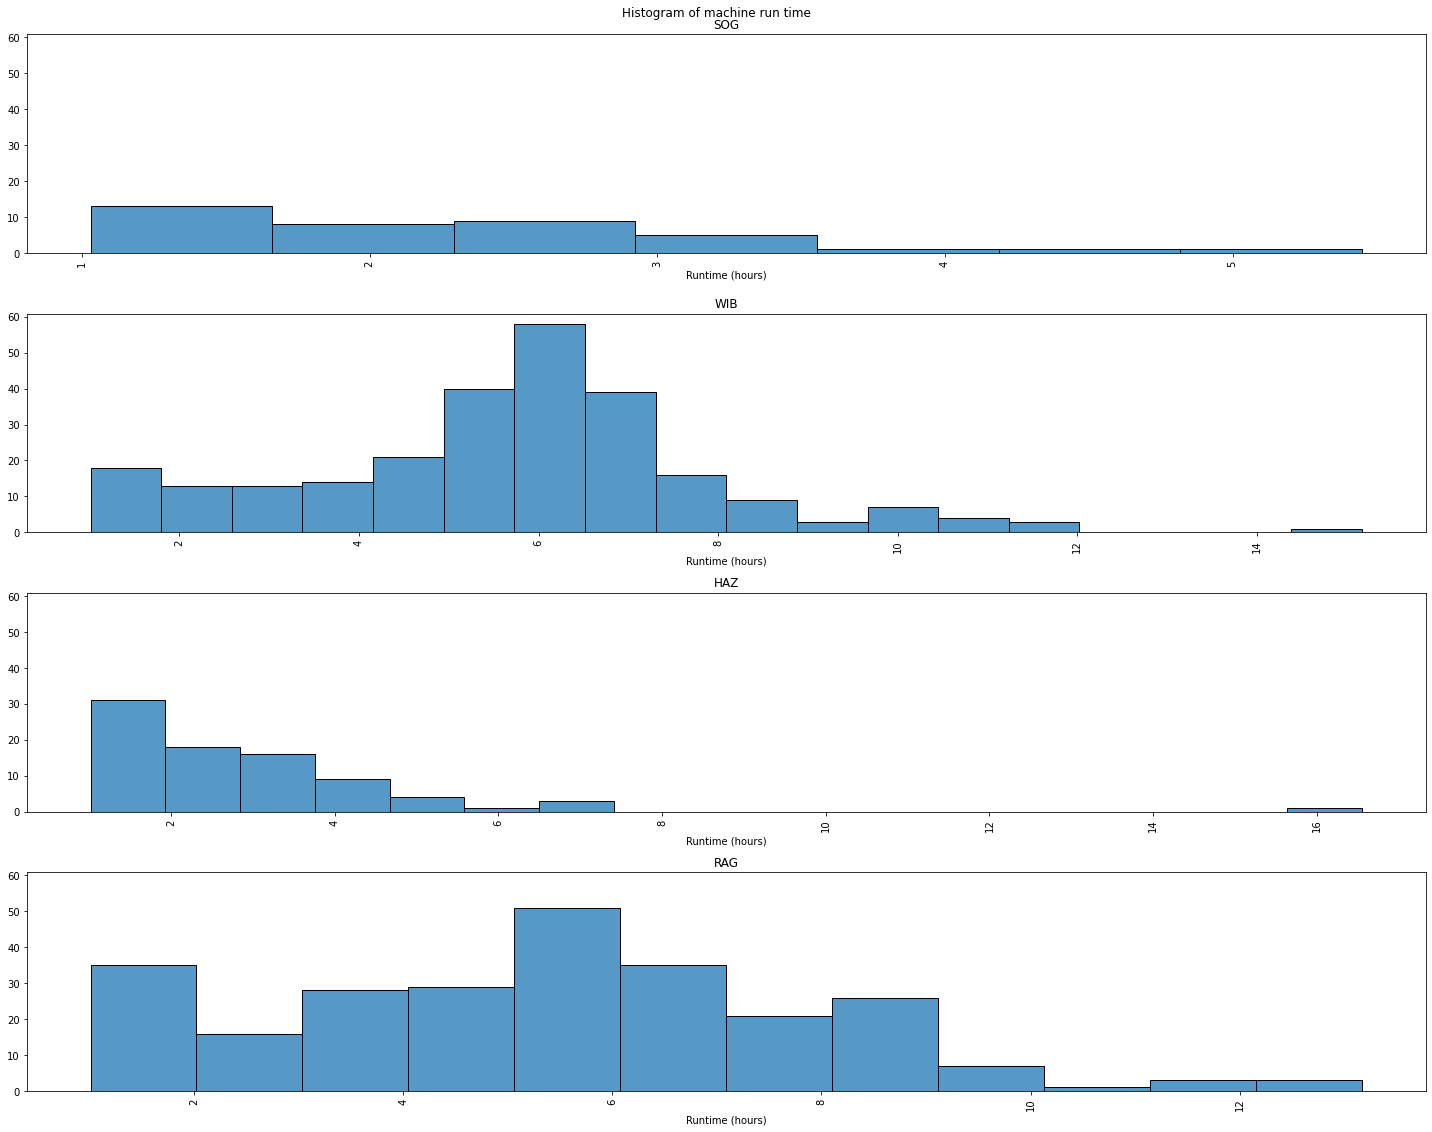

In [71]:
# define subplot grid
fig, axs = plt.subplots(nrows=4, ncols=1, sharex=False,
                        sharey=True,figsize=(20, 16), gridspec_kw={'height_ratios': [1, 1, 1, 1]})
plt.subplots_adjust(hspace=0.5)
fig.suptitle("Histogram of machine run time")
machine_location = daily_df.machine_location.unique()
axes = axs.flatten()
# # loop through sites and axes
for s, ax in zip(machine_location, axes):
    g = sns.histplot(data=daily_df[(daily_df.runtime_hours > 1) & (daily_df.machine_location == s)],
                    x='runtime_hours', ax=ax)
    g.tick_params(axis='x', rotation=90)
    g.set(ylabel=None, title=s, xlabel='Runtime (hours)')
fig.tight_layout()

In [41]:
print('Runtime hours per machine per day summary statistics\n')
print(daily_df[(daily_df.runtime_hours > 1)].groupby(['machine_location']).runtime_hours.describe()[[
    'count', '25%', '50%', '75%', 'max'
]])
print('\n By week: \n')
print(daily_df[(daily_df.runtime_hours > 1)].groupby(['machine_location', 'week']).runtime_hours.describe()[[
    'count', '25%', '50%', '75%', 'max'
]])

Runtime hours per machine per day summary statistics

                  count     25%    50%     75%    max
machine_location                                     
HAZ                83.0  1.5000  2.540  3.5800  16.55
RAG               255.0  3.4700  5.460  6.9450  13.17
SOG                38.0  1.5625  2.085  2.7575   5.45
WIB               259.0  4.2650  5.890  6.8150  15.17

 By week: 

                       count     25%    50%      75%    max
machine_location week                                      
HAZ              3       1.0  4.4700  4.470   4.4700   4.47
                 4       3.0  1.3400  1.390   1.9550   2.52
                 5       5.0  1.7600  1.820   2.7400   2.93
                 6       9.0  1.3300  3.320   3.7900   4.76
                 7      12.0  2.3075  2.610   3.0475   4.73
                 8       9.0  1.3600  2.110   2.7100   3.66
                 9       8.0  1.3050  1.730   2.3075   6.53
                 10     10.0  2.0725  2.875   3.4600   3.95
         